In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


def kalman_filter(init=0, v_init=0):
    my_filter = KalmanFilter(dim_x=2, dim_z=1)  # dim_x: size of the state vector
                                                # dim_z: size of the measurement vector

    dt = 0.1
    my_filter.x = np.array([[init, v_init]]).T     # x, vx

    my_filter.F = np.array([[1, dt],      # state transition matrix
                            [0, 1]])      

    my_filter.H = np.array([[1, 0]])       # Measurement function    

    my_filter.P = np.array([[1, 0],         # covariance matrix
                            [0, 1]])       

    my_filter.R = np.array([[0.1]])             # state uncertainty                  

    my_filter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=10) # process uncertainty
    
    return my_filter

In [2]:
import time
import numpy as np

EPS = np.finfo(float).eps

def linear_func_coefficients(p1, p2):
    """
    Funkcja zwracająca współczynniki prostej przechodzącej przez 2 punkty p1 i p2
    """

    if (p2[0] - p1[0]) == 0:
        a = (p2[1]-p1[1])/(EPS)
    else:
        a = (p2[1]-p1[1])/(p2[0]-p1[0])
    b = p1[1] - a*p1[0]
    return a, b

def breaking_distance(v):
    """ 
    Parameters:
        v - velocity
        t - time of react
        f - coefficient of friction (0.7 on dry asphalt, 0.3 on wet)
        G - slope of the road expressed in decimal value
    Return:
        s - distance of breaking, formula AASHTO
    """
    t = 0
    f = 0.2
    G = 0

    s = (0.278 * t * v) + v**2 / (254 * (f + G))
    return s


def calculate_distance(track, id):
    distance = math.sqrt(track[-1][0]**2 + track[-1][1]**2) - 1.5 # dystans w lini prostej
    # distance = track[-1][1] # y
    return distance

def x_speed_func(p1, p2, diff_frames):
    """
        v = s / t
    """
    # x_speed = (p1[0] - p2[0])/(0.1)
    x_speed = (p1[0] - p2[0])/(0.1*diff_frames)
    return x_speed

def dangerous_situation_func(track, id):
    """
    Frame rate: 10 Hz

    """
    distance = calculate_distance(track, id)
    # Gdy jest możliwe wyznaczenie prostej (detekcja człowieka i przypisanie ID)
    if len(track) > 1:
        distance = math.sqrt(track[-1][0]**2 + track[-1][1]**2) - 1.5
        y_distance = track[-1][1]
        x_distance = track[-1][0]
        
        p1, p2 = track[-2], track[-1]
        a, b = linear_func_coefficients(p1, p2)
        x_speed = x_speed_func(p1, p2, len(track)-1)
        s_break = breaking_distance(abs(x_speed))

        if a == 0:
            a = EPS

        acc_1_x = (2-b)/a
        acc_2_x = (-2-b)/a

        # Jeżeli prosta wyznaczona z wektora prędkości pieszego przetnie obszar samochodu + dodatkowa przestrzeń 
        if (acc_1_x < 5 and acc_1_x > 0) or (acc_1_x > 5 and acc_2_x < 0) or (acc_2_x > 5 and acc_1_x < 0) or (acc_2_x < 5 and acc_2_x > 0):
            # Człowiek się oddala
            if x_speed < 0 :
                if distance < 5 :
                    return "BE CAREFUL", (0, 155, 100), distance
                else:
                    return "GO AHEAD", (0, 255, 0), distance
            elif x_speed > 80:
                return "MISTAKE", (255, 0, 0), distance
            else:
                if 0 < x_distance < 30:
                    if -7 < y_distance < 7:
                        if x_speed < 3:
                            return "BE CAREFUL", (0, 155, 100), distance
                        elif x_speed < 8:
                            return "SLOW DOWN", (0, 100, 155), distance
                        else:
                            print(f"BREAK: {id}\n")
                            return "BREAK", (0, 0, 255), distance
                    else:
                        return "GO AHEAD", (0, 255, 0), distance
                else: 
                    return "GO AHEAD", (0, 255, 0), distance          
        # Gdy prosta nie przecina obszaru wokół samochodu:
        else:
            if 0 < x_distance < 20:
                # Jeżeli wartość odległości współrzędnej y od obiektu jest mniejsza niż 1 m: ZWOLNIJ 
                if y_distance < 2 and y_distance > -2:
                    return "BE CAREFUL", (0, 100, 155), distance
                # W przeciwnym razie: JEDŹ DALEJ
                else:
                    return "GO AHEAD", (0, 255, 0), distance
            else:
                return "GO AHEAD", (0, 255, 0), distance
    # Brak detekcji ludzi: JEDŹ DALEJ
    else :
        return "GO AHEAD", (0, 255, 0), distance


def correct_track(track):
    if len(track) == 3:
        movement = track[-1] - track[-2]
        previous_movement = track[-2] - track[-3]

        # jeśli aktualny ruch różni się znacznie od poprzedniego, dokonuje korekcji
        if any(movement > previous_movement*3 ):
            track[-1] = track[-2] + previous_movement

In [ ]:
import cv2
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ouster import client
from ouster import pcap
# from ouster.sdk import viz
from ouster.client import Scans
from ouster.client.data import LidarScan
from ultralytics import YOLO
from contextlib import closing
from collections import defaultdict


# Load the YOLOv8 model
model = YOLO('weights/best_s.pt')

# Paths to pcap and json files
metadata_path = "C:/Users/szyme/Ouster/data/PKR_test1/test4.json"
pcap_path = "C:/Users/szyme/Ouster/data/PKR_test1/test4.pcap"

# Making PacketSource from data
with open(metadata_path, 'r') as f:
    metadata = client.SensorInfo(f.read())


fps = int(str(metadata.mode)[-2:])
width = int(str(metadata.mode)[:4])
height = int(str(metadata.prod_line)[5:])

pcap_file = pcap.Pcap(pcap_path, metadata)

xyzlut = client.XYZLut(metadata) #call cartesian lookup table

# Store the track history
track_history = defaultdict(lambda: [])
# track_history_filtered_x = defaultdict(lambda: kalman_filter())
# track_history_filtered_y = defaultdict(lambda: kalman_filter())
track_history_filtered_x = {}
track_history_filtered_y = {}
x_speed_history = []

with closing(client.Scans(pcap_file)) as scans:

    save_path = "C:/Users/szyme/Ouster/YOLOv8/results_mp4/res_s_1100.mp4"
    vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    i = 0
    for scan in scans:
        i += 1
        # Create signal image
        sig_field = scan.field(client.ChanField.SIGNAL)
        sig_destaggered = client.destagger(pcap_file.metadata, sig_field)
    
        # Define a scaling factor based on the values (adjust this as needed)
        scaling_factor = 0.004
        # Lower the elements based on their values
        lowered_arr = sig_destaggered / (0.5 + scaling_factor * sig_destaggered) # BASIC

        # Convert to uint8
        signal_image = lowered_arr.astype(np.uint8)
        combined_img = np.dstack((signal_image, signal_image, signal_image))

        # Create range image (for localization, distance measurement)
        range_field = scan.field(client.ChanField.RANGE)
        range_image = client.destagger(pcap_file.metadata, range_field)

        # xyz_destaggered = xyzlut(range_field)
        xyz_destaggered = client.destagger(metadata, xyzlut(scan)) #to adjust for the pixel staggering that is inherent to Ouster lidar sensor raw data

        # Predict and track
        results = model.track(source=combined_img, persist=True, imgsz=1024, tracker='bytetrack.yaml')

        boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

        if (results[0].boxes.id == None):
            ids = ''
        else:
            ids = results[0].boxes.id.cpu().numpy().astype(int)

        OUTPUT = "GO AHEAD"
        color = (0, 255, 0)
        
        for box, id in zip(boxes, ids):

            center_x, center_y = int((box[0] + box[2])/2), int((box[1] + box[3])/2)

            xyz_val = xyz_destaggered[(center_y, center_x)] #get the (x,y,z) coordinates with the lookup table 

            track = track_history[id] #save the (x,y,z) coordinates for distance calculation

            # print(xyz_val[0])
            if len(track) > 0:
                if abs(xyz_val[0] - track[-1][0]) > 4 or abs(xyz_val[1] - track[-1][1]) > 4:
                    track.append(track[-1])
                else:
                    track.append(xyz_val)
            else:
                track.append(xyz_val)

            if len(track) >= 2:
                x_0 = track[0][0]
                y_0 = track[0][1]
                vx_0 = (track[1][0] - x_0)/0.1
                vy_0 = (track[1][1] - y_0)/0.1
                value = track_history_filtered_x.get(id)
                if value is None:
                    track_history_filtered_x[id] = kalman_filter(init=x_0, v_init=vx_0)
                    track_history_filtered_y[id] = kalman_filter(init=y_0, v_init=vy_0)
                    track_filtered_x = track_history_filtered_x[id]
                    track_filtered_y = track_history_filtered_y[id]
                else:
                    track_filtered_x = track_history_filtered_x[id]#.get(id, kalman_filter(init=track[0][0]))
                    track_filtered_y = track_history_filtered_y[id]#.get(id, kalman_filter(init=track[0][1]))

                track_filtered_x.predict()
                track_filtered_y.predict()

                track_filtered_x.update([track[-1][0]])
                track_filtered_y.update([track[-1][1]])
                out_x = track_filtered_x.x
                out_y = track_filtered_y.x

            
            # if id == 130:
            #     print(out[])


            # check if not mistake
            # correct_track(track)

            # result will be one of: BREAK, SLOW_DOWN, BE_CAREFUL, GO_AHEAD 
            OUTPUT, color, distance = dangerous_situation_func(track, id)
            # OUTPUT = f"X: {out_x[0,0]:0.3f}, V_x: {out_x[1,0]:0.3f}"

            # if len(track) > 3:
            #     track.pop(0)


            cv2.rectangle(combined_img, (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.rectangle(combined_img, (box[0], box[1]+2), (box[0]+160, box[1]-12), (255, 255, 255), -1)
            cv2.putText(combined_img, f"Id {id}; dist: {distance:0.2f} m", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # if isinstance(relative_speed, float):
        #     cv2.putText(combined_img, f"{OUTPUT:0.2f}", (400, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        # elif isinstance(relative_speed, str):
        #     cv2.putText(combined_img, f"{OUTPUT}", (400, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.putText(combined_img, f"{OUTPUT}", (470, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Stream results
        if True:
            cv2.imshow("YOLOv8 Tracking", combined_img)
            cv2.waitKey(1)  # 1 millisecond

        vid_writer.write(combined_img)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        # time.sleep(0.5)
        if i >= 1100:
            break

    vid_writer.release()
    cv2.destroyAllWindows()

-4.521869673842787
-4.521869673842787


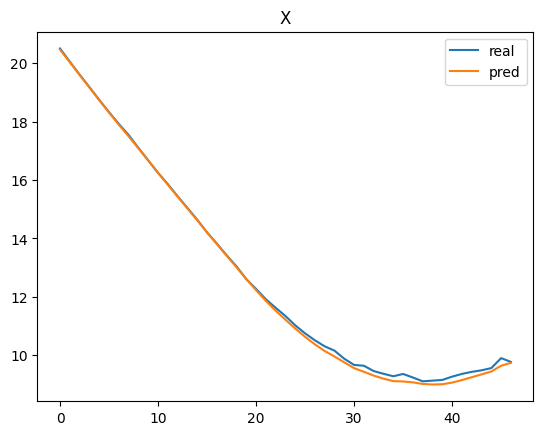

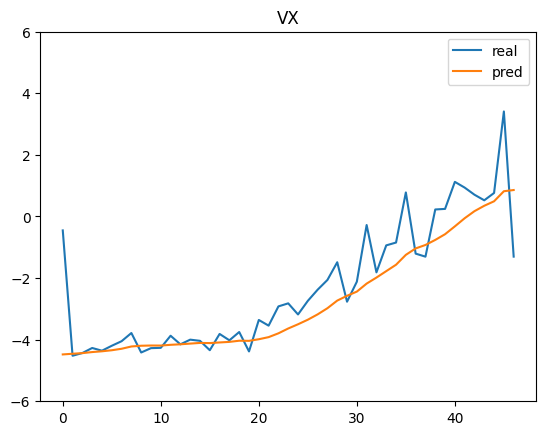

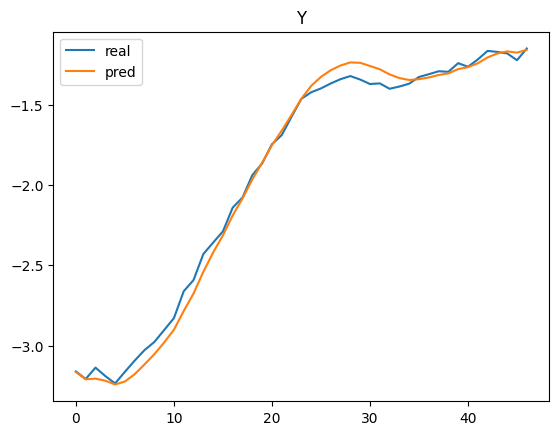

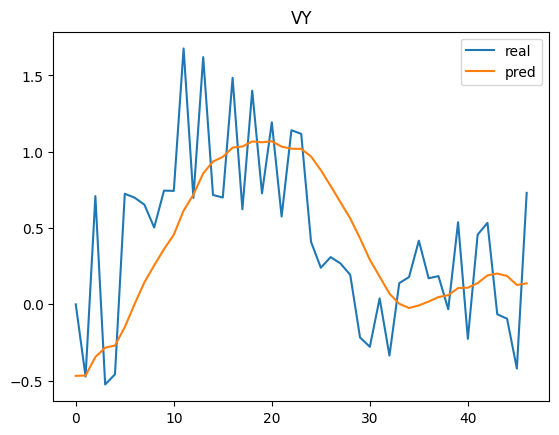

In [15]:
x_0 = track_history[143][0][0]
y_0 = track_history[143][0][1]
vx_0 = (track_history[143][1][0] - x_0)/0.1
vy_0 = (track_history[143][1][1] - y_0)/0.1
print(vx_0)
print(vx_0)

my_filter_x = kalman_filter(init=x_0, v_init=vx_0) #init=track_history[99][0][0]
my_filter_y = kalman_filter(init=y_0, v_init=vy_0)

real_x = [[], [], []]
pred_x = [[], [], []]
real_y = [[], [], []]
pred_y = [[], [], []]

for idx, xyz in enumerate(track_history[143]):
    real_x[0].append(idx)
    real_x[1].append(xyz[0])
    real_y[0].append(idx)
    real_y[1].append(xyz[1])
    if idx == 0:
        real_x[2].append(track_history[143][idx+1][0] - track_history[143][idx][0])
        real_y[2].append(0)
    else:
        real_x[2].append((real_x[1][-1]-real_x[1][-2])/(0.1))
        real_y[2].append((real_y[1][-1]-real_y[1][-2])/(0.1))
    # if idx >= 0:
    my_filter_x.predict()
    my_filter_y.predict()
    my_filter_x.update([xyz[0]])
    my_filter_y.update([xyz[1]])

    x = my_filter_x.x
    y = my_filter_y.x
    pred_x[0].append(idx)
    pred_x[1].append(x[0])
    pred_x[2].append(x[1])
    pred_y[0].append(idx)
    pred_y[1].append(y[0])
    pred_y[2].append(y[1])

plt.plot(real_x[0], real_x[1])
plt.plot(pred_x[0], pred_x[1])
plt.title("X")
plt.legend(["real", "pred"])
plt.show()

plt.plot(real_x[0], real_x[2])
plt.plot(pred_x[0], pred_x[2])
plt.ylim(-6,6)
plt.title("VX")
plt.legend(["real", "pred"])
plt.show()

plt.plot(real_y[0], real_y[1])
plt.plot(pred_y[0], pred_y[1])
plt.title("Y")
plt.legend(["real", "pred"])
plt.show()

plt.plot(real_y[0], real_y[2])
plt.plot(pred_y[0], pred_y[2])
plt.title("VY")
plt.legend(["real", "pred"])
plt.show()